In [17]:
import Random#, logging
using  Plots, CSV, Gen#, Dates
using DataFrames: DataFrame
include("../Step1-Data/DataGen.jl")
include("../Step1.5-Graphing_Model/GraphMaking.jl")
# Disable logging, because @animate is verbose otherwise
#Logging.disable_logging(Logging.Info);

In [6]:
xs = dataframe.Date
ys = dataframe.DetrendedN1

392-element Vector{Float64}:
   67245.996498657
    -764.409188023614
   15115.1767155065
   -7266.18401132422
  -15152.0726639872
    2538.03868334989
  -24733.3596236665
  -26416.0848277806
  -24363.002522285
  -41226.6966241169
       ⋮
      -1.04706448546529e6
      -1.14184988436826e6
      -1.43424508656232e6
      -1.54820081391516e6
      -1.288771541268e6
       2.4175562375947e6
 -916189.593666784
       1.51841440688562e7
      -1.39620526862083e6

In [37]:
@gen function regression_with_outliers(xs::Vector{<:Real})
    # First, generate some parameters of the model. We make these
    # random choices, because later, we will want to infer them
    # from data. The distributions we use here express our assumptions
    # about the parameters: we think the slope and intercept won't be
    # too far from 0; that the noise is relatively small; and that
    # the proportion of the dataset that don't fit a linear relationship
    # (outliers) could be anything between 0 and 1.
    slope ~ normal(0, 1000)
    intercept ~ normal(0, 1000)
    noise ~ gamma(100, 100)
    prob_outlier ~ uniform(0, 1)
    
    # Next, we generate the actual y coordinates.
    n = length(xs)
    ys = Float64[]
    
    for i = 1:n
        # Decide whether this point is an outlier, and set
        # mean and standard deviation accordingly
        if ({:data => i => :is_outlier} ~ bernoulli(prob_outlier))
            (mu, std) = (0., 1000000)
        else
            (mu, std) = (xs[i] * slope + intercept, noise)
        end
        # Sample a y value for this point
        push!(ys, {:data => i => :y} ~ normal(mu, std))
    end
    ys
end;

In [14]:
function serialize_trace(trace)
    (xs,) = Gen.get_args(trace)
    n = length(xs)
    Dict(:slope => trace[:slope],
         :inlier_std => trace[:noise],
         :points => zip(xs, [trace[:data => i => :y] for i in 1:length(xs)]),
         :xs => xs,
         :ys => [xs[i] * trace[:slope] + trace[:intercept] for i in 1:n],
         :intercept => trace[:intercept],
         :outliers => [trace[:data => i => :is_outlier] for i in 1:length(xs)])
end

serialize_trace (generic function with 1 method)

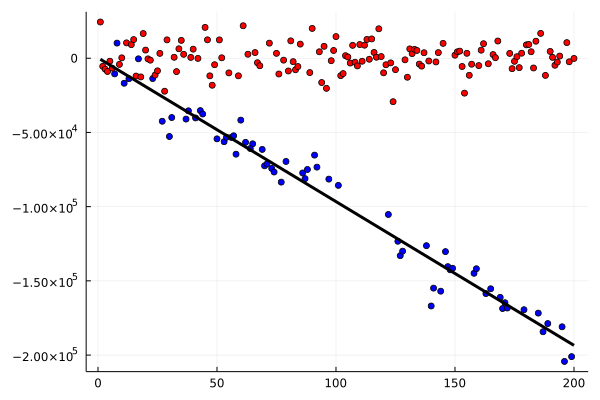

In [30]:
ts = collect(range(1, stop=200, length=200))
traces = Gen.simulate(regression_with_outliers, (ts,));
visualize_trace(traces)

In [31]:
function make_constraints(ys::Vector{Float64})
    constraints = Gen.choicemap()
    for i=1:length(ys)
        constraints[:data => i => :y] = ys[i]
    end
    constraints
end;

In [32]:
observations = make_constraints(ys);

In [33]:
# Perform a single block resimulation update of a trace.
function block_resimulation_update(tr)
    # Block 1: Update the line's parameters
    line_params = select(:noise, :slope, :intercept)
    (tr, _) = mh(tr, line_params)
    
    # Blocks 2-N+1: Update the outlier classifications
    (xs,) = get_args(tr)
    n = length(xs)
    for i=1:n
        (tr, _) = mh(tr, select(:data => i => :is_outlier))
    end
    
    # Block N+2: Update the prob_outlier parameter
    (tr, _) = mh(tr, select(:prob_outlier))
    
    # Return the updated trace
    tr
end;



In [34]:
function block_resimulation_inference(xs, ys)
    observations = make_constraints(ys)
    (tr, W) = generate(regression_with_outliers, (xs,), observations)
    for iter=1:100
        tr = block_resimulation_update(tr)
    end
    tr
end;

In [38]:
t, = generate(regression_with_outliers, (xs,), observations)
dur = 50
viz = Plots.@animate for i in 1:dur
    global t
    t = block_resimulation_update(t)
    visualize_trace(t; title="Iteration $i/$dur")
end;
gif(viz)